# DLBasics2023 最終課題
実行結果付き。
参考データ収集用.（Cosine Annealing 100回）
### 作者： tfujiwara
### 日付： 2023-Aug-02

## 課題
第11回「変分オートエンコーダ（VAE）を用いてFasionMNISTの画像を生成してみましょう」<br>
を発展させ、学習率探索プログラムを開発する

### 目標

課題の目標値は「NLL（負の対数尤度） 235」であったが、これにこだわらず、
自動探索により、良い検証結果の出る学習率が得られることとする。
以下の、オリジナル課題ルールは、あえて変更せず、**学習率とエポック数以外の条件を固定した中で、最良の検証結果を出す。**

### オリジナル課題ルール

- 訓練データは`x_train`，テストデータは`x_test`で与えられます．
- 下のセルで指定されている`x_train`以外の学習データは使わないでください．

### 評価方法

- 評価は生成画像の検証データに対するNLL（負の対数尤度）とした。<br>（オリジナル課題は、テストデータに対するNLL）

\begin{equation}
-\sum_{i=1}^Dx_i\log\hat{x_i}+(1-x_i)\log(1-\hat{x_i})
\end{equation}

### ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み（このセルは修正しないでください）

In [ ]:
import numpy as np
import pandas as pd
import torch

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

# 学習データ
x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_train.npy')
# テストデータ
x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_test.npy')


class dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test.reshape(-1, 784).astype('float32') / 255

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

trainval_data = dataset(x_train)
test_data = dataset(x_test)

### VAEの実装


In [ ]:
batch_size = 32

val_size = 10000
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from typing import Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"


# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデルの実装
class VAE(nn.Module):
    # WRITE ME
    def __init__(self, z_dim: int) -> None:
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction

自分の関数の追加

In [ ]:
import datetime
import pytz
import math
timezone = 'Europe/Budapest'

def datetime_now():
    new_timezone = pytz.timezone(timezone)
    return datetime.datetime.now().astimezone(new_timezone)

class XPrint:
    ### 画面と同じものを記録する。
    def __init__(self, filename, mystr):
        self.filename = filename
        if ( mystr != "" ):
            self.message_time(mystr)
    def __call__(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
    def message(self, mystr):
        try:
            with open(self.filename, "a") as f:
                f.write("{}\n".format(mystr))
        except FileNotFoundError:
            print("* "+mystr)
            return
        print("  "+mystr)
    def message_time(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
xprint = XPrint('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/xprint{}.txt'.format(datetime_now().strftime("%Y%m%d")), "")

class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)
        return lr

  2023/07/29 11:59:24 EPOCH:1, Train Lower Bound:299.617920, (9.382020, 290.235901), Valid Lower Bound:261.883209 lr=0.00020000 最小値更新
  2023/07/29 11:59:41 EPOCH:2, Train Lower Bound:257.786194, (11.238808, 246.547394), Valid Lower Bound:251.014084 lr=0.00040000 最小値更新
  2023/07/29 11:59:59 EPOCH:3, Train Lower Bound:250.614746, (11.642273, 238.972458), Valid Lower Bound:244.678635 lr=0.00060000 最小値更新
  2023/07/29 12:00:16 EPOCH:4, Train Lower Bound:247.293930, (12.017821, 235.276108), Valid Lower Bound:242.940598 lr=0.00080000 最小値更新
  2023/07/29 12:00:33 EPOCH:5, Train Lower Bound:245.376816, (12.251584, 233.125229), Valid Lower Bound:241.801300 lr=0.00100000 最小値更新
  2023/07/29 12:00:50 EPOCH:6, Train Lower Bound:243.792374, (12.467814, 231.324570), Valid Lower Bound:239.729675 lr=0.00100000 最小値更新
  2023/07/29 12:01:07 EPOCH:7, Train Lower Bound:242.801682, (12.577939, 230.223755), Valid Lower Bound:239.673920 lr=0.00099973 最小値更新
  2023/07/29 12:01:26 EPOCH:8, Train Lower Bound:242.132

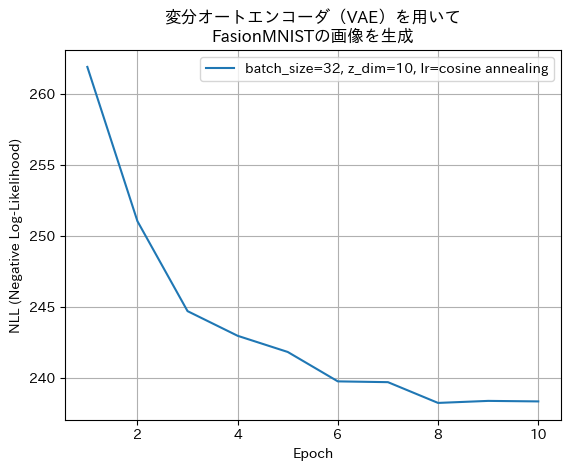

  2023/07/29 12:02:20 EPOCH:11, Train Lower Bound:240.717300, (12.758897, 227.958405), Valid Lower Bound:237.717957 lr=0.00099318 最小値更新
  2023/07/29 12:02:38 EPOCH:12, Train Lower Bound:240.491791, (12.781169, 227.710648), Valid Lower Bound:237.536835 lr=0.00099019 最小値更新
  2023/07/29 12:02:55 EPOCH:13, Train Lower Bound:240.225525, (12.801457, 227.424057), Valid Lower Bound:236.959717 lr=0.00098666 最小値更新
  2023/07/29 12:03:13 EPOCH:14, Train Lower Bound:239.983948, (12.842187, 227.141739), Valid Lower Bound:236.701630 lr=0.00098260 最小値更新
  2023/07/29 12:03:30 EPOCH:15, Train Lower Bound:239.783417, (12.827102, 226.956314), Valid Lower Bound:237.016220 lr=0.00097802 
  2023/07/29 12:03:48 EPOCH:16, Train Lower Bound:239.625061, (12.844588, 226.780487), Valid Lower Bound:236.951126 lr=0.00097291 
  2023/07/29 12:04:06 EPOCH:17, Train Lower Bound:239.456543, (12.842170, 226.614365), Valid Lower Bound:236.982880 lr=0.00096728 
  2023/07/29 12:04:24 EPOCH:18, Train Lower Bound:239.340820, (

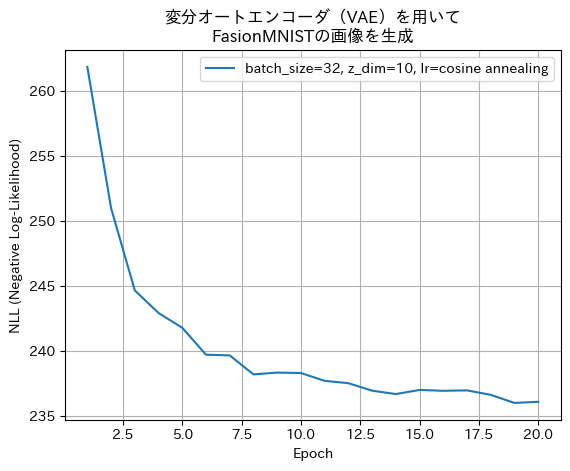

  2023/07/29 12:05:19 EPOCH:21, Train Lower Bound:238.955032, (12.913885, 226.041138), Valid Lower Bound:236.333115 lr=0.00093974 
  2023/07/29 12:05:37 EPOCH:22, Train Lower Bound:238.844757, (12.914159, 225.930603), Valid Lower Bound:236.365265 lr=0.00093163 
  2023/07/29 12:05:54 EPOCH:23, Train Lower Bound:238.741409, (12.917730, 225.823669), Valid Lower Bound:235.915878 lr=0.00092305 最小値更新
  2023/07/29 12:06:12 EPOCH:24, Train Lower Bound:238.635345, (12.916660, 225.718689), Valid Lower Bound:235.665283 lr=0.00091400 最小値更新
  2023/07/29 12:06:30 EPOCH:25, Train Lower Bound:238.539886, (12.941027, 225.598892), Valid Lower Bound:236.283813 lr=0.00090451 
  2023/07/29 12:06:48 EPOCH:26, Train Lower Bound:238.452759, (12.933589, 225.519180), Valid Lower Bound:235.712189 lr=0.00089457 
  2023/07/29 12:07:05 EPOCH:27, Train Lower Bound:238.327759, (12.938060, 225.389709), Valid Lower Bound:235.599640 lr=0.00088420 最小値更新
  2023/07/29 12:07:22 EPOCH:28, Train Lower Bound:238.265472, (12.94

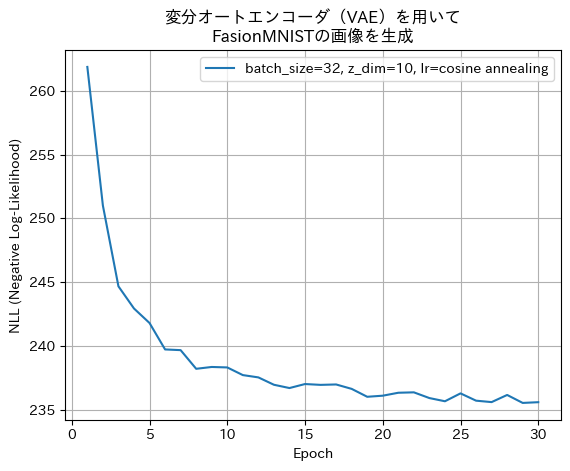

  2023/07/29 12:08:17 EPOCH:31, Train Lower Bound:238.043350, (12.992815, 225.050522), Valid Lower Bound:236.011856 lr=0.00083864 
  2023/07/29 12:08:35 EPOCH:32, Train Lower Bound:237.938217, (12.976460, 224.961746), Valid Lower Bound:235.375946 lr=0.00082629 最小値更新
  2023/07/29 12:08:53 EPOCH:33, Train Lower Bound:237.891510, (12.988537, 224.902969), Valid Lower Bound:235.299789 lr=0.00081359 最小値更新
  2023/07/29 12:09:10 EPOCH:34, Train Lower Bound:237.828369, (13.020082, 224.808304), Valid Lower Bound:235.063599 lr=0.00080054 最小値更新
  2023/07/29 12:09:28 EPOCH:35, Train Lower Bound:237.759995, (13.023598, 224.736389), Valid Lower Bound:235.683685 lr=0.00078716 
  2023/07/29 12:09:46 EPOCH:36, Train Lower Bound:237.634659, (13.004068, 224.630585), Valid Lower Bound:234.977554 lr=0.00077347 最小値更新
  2023/07/29 12:10:05 EPOCH:37, Train Lower Bound:237.610794, (13.035013, 224.575775), Valid Lower Bound:235.430267 lr=0.00075948 
  2023/07/29 12:10:22 EPOCH:38, Train Lower Bound:237.541229, (

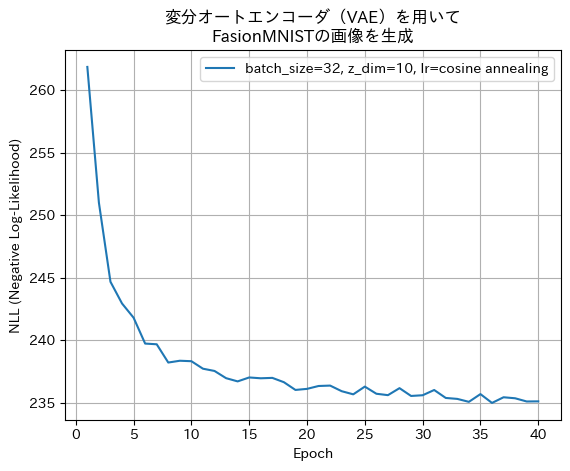

  2023/07/29 12:11:18 EPOCH:41, Train Lower Bound:237.328049, (13.036456, 224.291595), Valid Lower Bound:235.195419 lr=0.00070085 
  2023/07/29 12:11:36 EPOCH:42, Train Lower Bound:237.263489, (13.059842, 224.203644), Valid Lower Bound:234.841461 lr=0.00068560 最小値更新
  2023/07/29 12:11:53 EPOCH:43, Train Lower Bound:237.208939, (13.055308, 224.153656), Valid Lower Bound:234.765320 lr=0.00067015 最小値更新
  2023/07/29 12:12:12 EPOCH:44, Train Lower Bound:237.151932, (13.056565, 224.095367), Valid Lower Bound:234.722137 lr=0.00065451 最小値更新
  2023/07/29 12:12:30 EPOCH:45, Train Lower Bound:237.111465, (13.097517, 224.013947), Valid Lower Bound:234.780319 lr=0.00063870 
  2023/07/29 12:12:48 EPOCH:46, Train Lower Bound:237.029648, (13.081988, 223.947632), Valid Lower Bound:234.783813 lr=0.00062274 
  2023/07/29 12:13:06 EPOCH:47, Train Lower Bound:236.934204, (13.056655, 223.877533), Valid Lower Bound:234.641800 lr=0.00060665 最小値更新
  2023/07/29 12:13:26 EPOCH:48, Train Lower Bound:236.884567, (

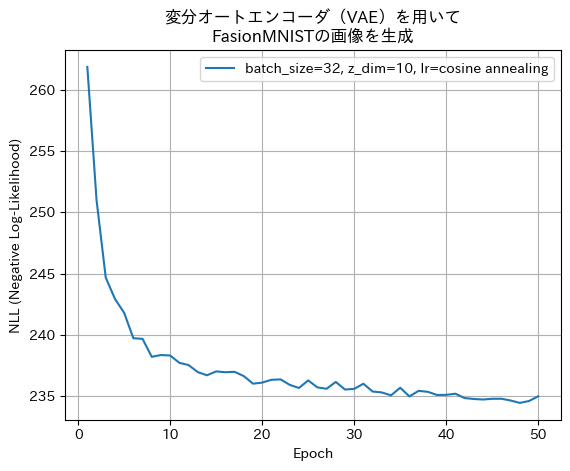

  2023/07/29 12:14:24 EPOCH:51, Train Lower Bound:236.751404, (13.127829, 223.623566), Valid Lower Bound:234.551666 lr=0.00054129 
  2023/07/29 12:14:42 EPOCH:52, Train Lower Bound:236.673233, (13.107992, 223.565231), Valid Lower Bound:234.502396 lr=0.00052479 
  2023/07/29 12:15:01 EPOCH:53, Train Lower Bound:236.600861, (13.129021, 223.471848), Valid Lower Bound:234.686478 lr=0.00050827 
  2023/07/29 12:15:21 EPOCH:54, Train Lower Bound:236.529953, (13.113846, 223.416092), Valid Lower Bound:234.547028 lr=0.00049173 
  2023/07/29 12:15:41 EPOCH:55, Train Lower Bound:236.509171, (13.131749, 223.377441), Valid Lower Bound:234.294586 lr=0.00047521 最小値更新
  2023/07/29 12:16:00 EPOCH:56, Train Lower Bound:236.432129, (13.116706, 223.315399), Valid Lower Bound:234.123901 lr=0.00045871 最小値更新
  2023/07/29 12:16:23 EPOCH:57, Train Lower Bound:236.377197, (13.130107, 223.247101), Valid Lower Bound:234.404648 lr=0.00044226 
  2023/07/29 12:16:42 EPOCH:58, Train Lower Bound:236.346344, (13.130601,

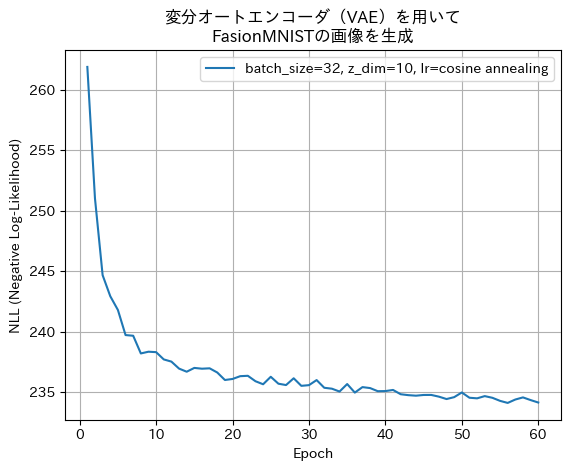

  2023/07/29 12:17:41 EPOCH:61, Train Lower Bound:236.168900, (13.143647, 223.025253), Valid Lower Bound:233.987122 lr=0.00037726 最小値更新
  2023/07/29 12:17:59 EPOCH:62, Train Lower Bound:236.125793, (13.144306, 222.981491), Valid Lower Bound:233.832794 lr=0.00036130 最小値更新
  2023/07/29 12:18:20 EPOCH:63, Train Lower Bound:236.073883, (13.156546, 222.917343), Valid Lower Bound:233.975296 lr=0.00034549 
  2023/07/29 12:18:39 EPOCH:64, Train Lower Bound:236.020081, (13.163241, 222.856827), Valid Lower Bound:233.935852 lr=0.00032985 
  2023/07/29 12:18:59 EPOCH:65, Train Lower Bound:235.975784, (13.140927, 222.834839), Valid Lower Bound:233.838913 lr=0.00031440 
  2023/07/29 12:19:22 EPOCH:66, Train Lower Bound:235.957047, (13.171114, 222.785934), Valid Lower Bound:233.858978 lr=0.00029915 
  2023/07/29 12:19:42 EPOCH:67, Train Lower Bound:235.889755, (13.161405, 222.728348), Valid Lower Bound:233.965805 lr=0.00028412 
  2023/07/29 12:20:04 EPOCH:68, Train Lower Bound:235.844284, (13.178540,

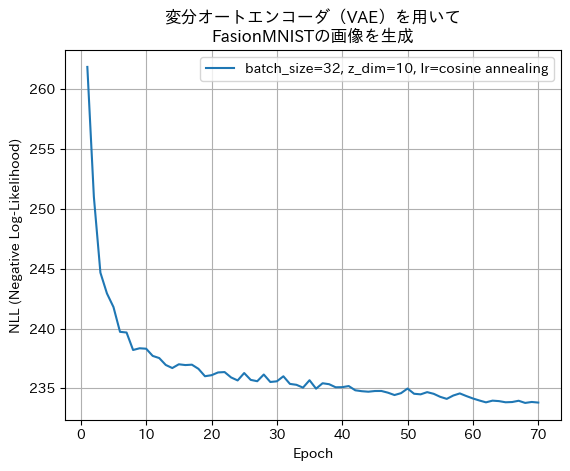

  2023/07/29 12:21:05 EPOCH:71, Train Lower Bound:235.735886, (13.186693, 222.549210), Valid Lower Bound:233.760361 lr=0.00022653 最小値更新
  2023/07/29 12:21:23 EPOCH:72, Train Lower Bound:235.689301, (13.197107, 222.492203), Valid Lower Bound:233.732132 lr=0.00021284 最小値更新
  2023/07/29 12:21:41 EPOCH:73, Train Lower Bound:235.628403, (13.175258, 222.453140), Valid Lower Bound:233.679214 lr=0.00019946 最小値更新
  2023/07/29 12:22:05 EPOCH:74, Train Lower Bound:235.608780, (13.186641, 222.422119), Valid Lower Bound:233.620651 lr=0.00018641 最小値更新
  2023/07/29 12:22:25 EPOCH:75, Train Lower Bound:235.564072, (13.202349, 222.361725), Valid Lower Bound:233.690002 lr=0.00017371 
  2023/07/29 12:22:46 EPOCH:76, Train Lower Bound:235.559845, (13.217101, 222.342743), Valid Lower Bound:233.623154 lr=0.00016136 
  2023/07/29 12:23:06 EPOCH:77, Train Lower Bound:235.516464, (13.213814, 222.302643), Valid Lower Bound:233.645721 lr=0.00014938 
  2023/07/29 12:23:26 EPOCH:78, Train Lower Bound:235.471832, (

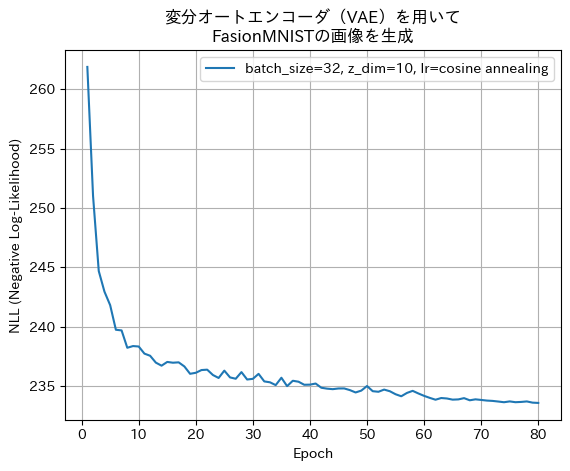

  2023/07/29 12:24:26 EPOCH:81, Train Lower Bound:235.401688, (13.221927, 222.179749), Valid Lower Bound:233.534363 lr=0.00010543 最小値更新
  2023/07/29 12:24:46 EPOCH:82, Train Lower Bound:235.356659, (13.222700, 222.133942), Valid Lower Bound:233.579453 lr=0.00009549 
  2023/07/29 12:25:05 EPOCH:83, Train Lower Bound:235.337387, (13.232578, 222.104782), Valid Lower Bound:233.519974 lr=0.00008600 最小値更新
  2023/07/29 12:25:25 EPOCH:84, Train Lower Bound:235.320557, (13.228883, 222.091660), Valid Lower Bound:233.518372 lr=0.00007695 最小値更新
  2023/07/29 12:25:43 EPOCH:85, Train Lower Bound:235.297531, (13.239244, 222.058304), Valid Lower Bound:233.454529 lr=0.00006837 最小値更新
  2023/07/29 12:26:01 EPOCH:86, Train Lower Bound:235.255173, (13.218371, 222.036819), Valid Lower Bound:233.436447 lr=0.00006026 最小値更新
  2023/07/29 12:26:19 EPOCH:87, Train Lower Bound:235.244797, (13.231952, 222.012833), Valid Lower Bound:233.493713 lr=0.00005264 
  2023/07/29 12:26:39 EPOCH:88, Train Lower Bound:235.2278

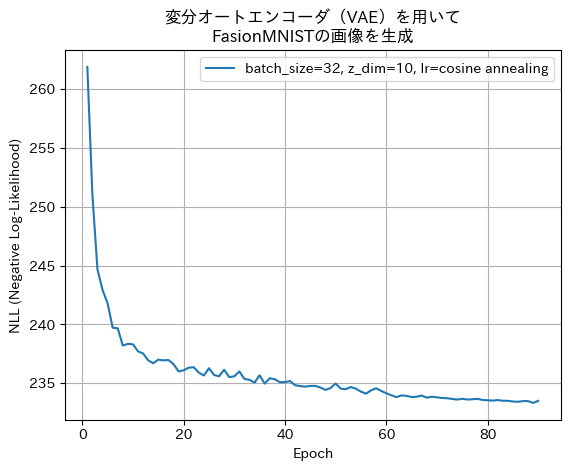

  2023/07/29 12:27:34 EPOCH:91, Train Lower Bound:235.163727, (13.230213, 221.933517), Valid Lower Bound:233.350388 lr=0.00002709 
  2023/07/29 12:27:55 EPOCH:92, Train Lower Bound:235.172409, (13.234034, 221.938385), Valid Lower Bound:233.398010 lr=0.00002198 
  2023/07/29 12:28:14 EPOCH:93, Train Lower Bound:235.167023, (13.239955, 221.927063), Valid Lower Bound:233.398087 lr=0.00001740 
  2023/07/29 12:28:34 EPOCH:94, Train Lower Bound:235.145477, (13.248096, 221.897400), Valid Lower Bound:233.428116 lr=0.00001334 
  2023/07/29 12:28:53 EPOCH:95, Train Lower Bound:235.129364, (13.239936, 221.889420), Valid Lower Bound:233.376404 lr=0.00000981 
  2023/07/29 12:29:12 EPOCH:96, Train Lower Bound:235.130096, (13.243471, 221.886642), Valid Lower Bound:233.402283 lr=0.00000682 
  2023/07/29 12:29:31 EPOCH:97, Train Lower Bound:235.109604, (13.244508, 221.865112), Valid Lower Bound:233.342209 lr=0.00000437 
  2023/07/29 12:29:49 EPOCH:98, Train Lower Bound:235.111023, (13.235676, 221.87535

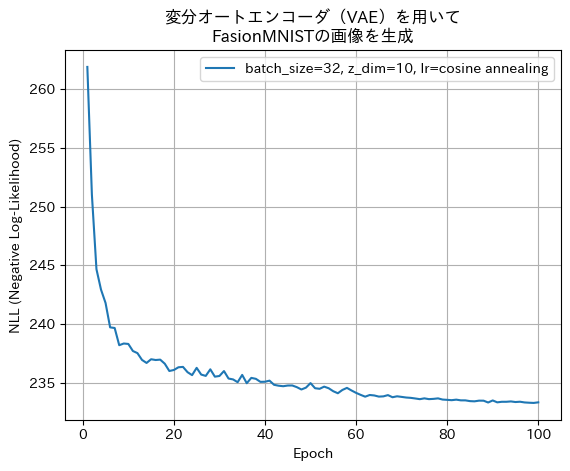

In [ ]:
z_dim = 10
assert z_dim >= 2
n_epochs = 100
lr=0.001     #0.00151 #0.001
scheduler = CosineScheduler(epochs=n_epochs, lr=lr)

model = VAE(z_dim).to(device)
#optimizer = optim.Adam(model.parameters(), lr=lr) #0.001
!pip install japanize_matplotlib >nul
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.clf()
gx = []
gy = []
title_font = {
    'color':  'black',
    'weight': 'bold',
    'size': 12,
}

min_valid_lower_bound = 9999                                                    # 最小値の初期値
for epoch in range(n_epochs):
    lr = scheduler(epoch)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.001


    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x in dataloader_train:

        # WRITE ME
        x = x.to(device)
        model.zero_grad()
        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)
        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in dataloader_valid:

        # WRITE ME
        x = x.to(device)
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())
    valid_lower_bound = np.average(losses_val)
    if valid_lower_bound < min_valid_lower_bound:
        min_valid_lower_bound = valid_lower_bound
        msg = "最小値更新"
    else:
        msg = ""
    xprint('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf lr=%.8lf %s' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val), lr, msg))
    gx.append(epoch+1)
    gy.append(np.average(losses_val))
    if (epoch+1) % 10 == 0:
        plt.plot(gx, gy, label=f'batch_size={batch_size}, z_dim={z_dim}, lr=cosine annealing')
        plt.xlabel(f"Epoch")                                     # グラフ表示用
        plt.ylabel(f"NLL (Negative Log-Likelihood)")                             # グラフ表示用
        plt.grid(True)
        plt.legend()
        plt.title(f"変分オートエンコーダ（VAE）を用いて\nFasionMNISTの画像を生成", fontdict=title_font)
        plt.show()

In [ ]:
import csv

sample_x = []
answer = []
model.eval()
for x in dataloader_test:
    x = x.to(device)
    y, _ = model(x)
    y = y.tolist()
    sample_x.extend(y)

with open('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/submission_pred.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(sample_x)
file.close()